<a href="https://colab.research.google.com/github/Raspberry765/deep-metric-learning/blob/main/SubCenterArcFaceMNIST_LoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install torchsummary
!pip install plotly==5.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchsummary import summary
import plotly.express as px
import plotly.graph_objects as go
from torch.utils.data.dataset import Subset

In [21]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(15488, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
        #max_pool2dのstrideのデフォルトはkernel_size
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))
            numpy_loss = loss.cpu().detach().numpy()
            loss_list.append(numpy_loss)
            #print(numpy_loss)            
    return loss_list


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))




## View some sample outliers

In [22]:


img_mean, img_std = (0.1307,), (0.3081,) #MNISTの平均と標準偏差  https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

In [24]:

device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
) #MNISTの平均と標準偏差を画像に対して前処理を行うためのパラメーター



dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform) #トランスフォームを適用して、ダウンロード
dataset2 = datasets.MNIST(".", train=False, transform=transform) #トランスフォームを適用して、ダウンロード



In [27]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)

model = Net().to("cuda")

test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size) #batch sizeは2**n deep learning C2 w2 optimization algorithms
optimizer = optim.Adam(model.parameters(), lr=0.01)#defalut lr=0.01 #ハイパーパラメーター
num_epochs = 2


### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)#ハイパーパラメーター
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

# train、validation、test datasetの作成
[train set validation testset役割](https://algorithm.joho.info/programming/python/keras-train-validation-test-dataset/)
[リンクテキスト](https://www.youtube.com/watch?v=swCf51Z8QDo)

In [28]:

#print(device)
n_samples = int( len(dataset1) )  # n_samples is 60000
train_size = int( n_samples * 0.8 ) # train_size is 48000
val_size = n_samples - train_size

# shuffleしてから分割してくれる.
train_dataset, val_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size])

print(len(train_dataset)) # 48000
print(len(val_dataset)) # 12000

#print(torch.cuda.is_available())

48000
12000


# Modelの表示

In [29]:

#print(model)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 22, 22]          73,856
         Dropout2d-4          [-1, 128, 11, 11]               0
            Linear-5                  [-1, 256]       3,965,184
Total params: 4,057,856
Trainable params: 4,057,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.04
Params size (MB): 15.48
Estimated Total Size (MB): 16.52
----------------------------------------------------------------


## Train the model

In [30]:
sum_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss_list = train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    print(loss_list)
    sum_loss_list.extend(loss_list)
    test(dataset1, dataset2, model, accuracy_calculator)
print(sum_loss_list)

Epoch 1 Iteration 0: Loss = 35.86091995239258
Epoch 1 Iteration 100: Loss = 8.39785385131836
Epoch 1 Iteration 200: Loss = 5.777891159057617
Epoch 1 Iteration 300: Loss = 3.7975645065307617
Epoch 1 Iteration 400: Loss = 1.1745444536209106
Epoch 1 Iteration 500: Loss = 4.183947563171387
Epoch 1 Iteration 600: Loss = 1.3772435188293457
Epoch 1 Iteration 700: Loss = 3.6168174743652344
Epoch 1 Iteration 800: Loss = 3.038300037384033
Epoch 1 Iteration 900: Loss = 2.282125949859619
[array(35.86092, dtype=float32), array(8.397854, dtype=float32), array(5.777891, dtype=float32), array(3.7975645, dtype=float32), array(1.1745445, dtype=float32), array(4.1839476, dtype=float32), array(1.3772435, dtype=float32), array(3.6168175, dtype=float32), array(3.0383, dtype=float32), array(2.282126, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 114.60it/s]
/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:65: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



Computing accuracy
Test set accuracy (Precision@1) = 0.9838
Epoch 2 Iteration 0: Loss = 2.7828691005706787
Epoch 2 Iteration 100: Loss = 2.1159543991088867
Epoch 2 Iteration 200: Loss = 1.9204118251800537
Epoch 2 Iteration 300: Loss = 2.1728858947753906
Epoch 2 Iteration 400: Loss = 0.5393368005752563
Epoch 2 Iteration 500: Loss = 2.1286845207214355
Epoch 2 Iteration 600: Loss = 2.2245006561279297
Epoch 2 Iteration 700: Loss = 0.33585768938064575
Epoch 2 Iteration 800: Loss = 0.7696933150291443
Epoch 2 Iteration 900: Loss = 1.9262058734893799
[array(2.782869, dtype=float32), array(2.1159544, dtype=float32), array(1.9204118, dtype=float32), array(2.172886, dtype=float32), array(0.5393368, dtype=float32), array(2.1286845, dtype=float32), array(2.2245007, dtype=float32), array(0.3358577, dtype=float32), array(0.7696933, dtype=float32), array(1.9262059, dtype=float32)]


100%|██████████| 313/313 [00:02<00:00, 111.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9866
[array(35.86092, dtype=float32), array(8.397854, dtype=float32), array(5.777891, dtype=float32), array(3.7975645, dtype=float32), array(1.1745445, dtype=float32), array(4.1839476, dtype=float32), array(1.3772435, dtype=float32), array(3.6168175, dtype=float32), array(3.0383, dtype=float32), array(2.282126, dtype=float32), array(2.782869, dtype=float32), array(2.1159544, dtype=float32), array(1.9204118, dtype=float32), array(2.172886, dtype=float32), array(0.5393368, dtype=float32), array(2.1286845, dtype=float32), array(2.2245007, dtype=float32), array(0.3358577, dtype=float32), array(0.7696933, dtype=float32), array(1.9262059, dtype=float32)]


# lossをプロットする

20


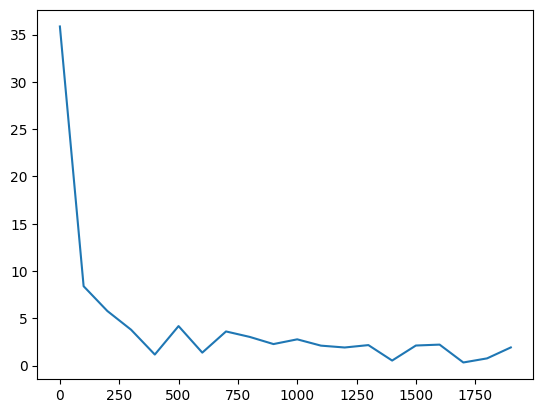

In [31]:
#print(type(loss_list[0]))
print(len(sum_loss_list))
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

plt.plot(x,y) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()

In [32]:
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

fig = go.Figure()
fig.add_trace(
go.Scatter(x=x,y=y)
)
fig.update_layout(
    xaxis_title = 'Number of Epoch',
    yaxis_title = 'Loss'
)
fig.show()

# modelを保存

In [33]:
torch.save(model, 'model_dml.pth')

#modelデータのロードをする
# trainデータを埋め込みする



In [34]:
load_model = torch.load('model_dml.pth')
train_embeddings, train_labels = get_all_embeddings(dataset1, load_model)

100%|██████████| 1875/1875 [00:21<00:00, 87.94it/s] 


## Get outliers(MNISTの文字データのtrainデータを異常検知している)

There are 96 outliers


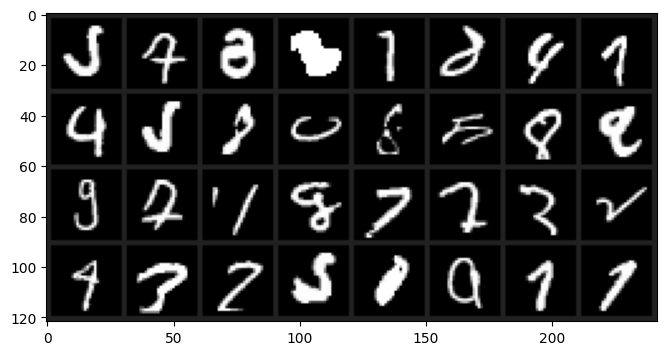

In [35]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers")
imshow_many(dataset1, outliers)

In [36]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers


# testデータを埋め込みする

In [37]:
test_embeddings, test_labels = get_all_embeddings(dataset2, model)

100%|██████████| 313/313 [00:03<00:00, 93.31it/s] 


## Get outliers(MNISTの文字データのtestデータを異常検知している)

There are 15 outliers(MNIST 10000 test items)


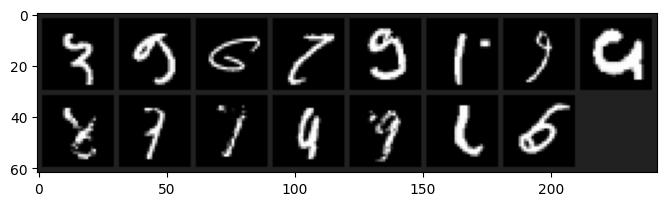

In [38]:
outliers, _ = loss_func.get_outliers(test_embeddings, test_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(MNIST 10000 test items)")
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset2, outliers)

In [39]:
# transform to normalize the data
fashion_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
fashion_trainset = datasets.FashionMNIST('.', download=True, train=True, transform=fashion_transform )
fashion_testset = datasets.FashionMNIST('.', download=True, train=False, transform=fashion_transform )

100%|██████████| 26421880/26421880 [00:02<00:00, 12465875.57it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210269.46it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3857385.46it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17933784.88it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



# train fashionデータとtest fashionデータを埋め込みする

In [40]:
train_fashion_embeddings, train_fashion_labels = get_all_embeddings(fashion_trainset, model)
test_fashion_embeddings, test_fashion_labels = get_all_embeddings(fashion_testset, model)

100%|██████████| 313/313 [00:03<00:00, 85.52it/s] 


In [41]:
outliers, _ = loss_func.get_outliers(train_fashion_embeddings, train_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 60000 items)")
outliers, _ = loss_func.get_outliers(test_fashion_embeddings, test_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 10000 items)")

There are 44997 outliers(train_fashion 60000 items)
There are 7509 outliers(train_fashion 10000 items)


64層まで
There are 43690 outliers(train_fashion 60000 items)
There are 7319 outliers(train_fashion 10000 items)